In [200]:
!pip install mlxtend


In [201]:
# ==============================================================
# Minimal merge: WHO (Depression, Suicide) + WB (GDP, etc.)
# Robust WHO header + country detection; INNER merge; NO imputation
# ==============================================================

from pathlib import Path
import glob
import re
import pandas as pd
import numpy as np

DATA_DIR = "."
YEAR_WB  = "2021"
MERGE_HOW = "inner"  # intersection of countries

# ----------------- utils -----------------
def find_file(patterns):
    if isinstance(patterns, str):
        patterns = [patterns]
    for pat in patterns:
        p = Path(pat)
        if p.exists():
            return str(p)
        hits = glob.glob(pat)
        if hits:
            return hits[0]
    raise FileNotFoundError(f"No file matched any of: {patterns}")

def read_csv_any(path):
    encs = ["utf-8", "utf-8-sig", "latin1", "cp1252"]
    seps = [None, ",", ";", "\t"]  # None => sniff (python engine)
    last = None
    for enc in encs:
        for sep in seps:
            try:
                if sep is None:
                    return pd.read_csv(path, encoding=enc, sep=sep, engine="python", on_bad_lines="skip")
                else:
                    return pd.read_csv(path, encoding=enc, sep=sep, engine="c", on_bad_lines="skip")
            except Exception as e:
                last = e
    raise last

def read_excel_any(path):
    try:
        return pd.read_excel(path)
    except Exception:
        return pd.read_excel(path, engine="openpyxl")

def read_table_any(path):
    suf = Path(path).suffix.lower()
    if suf in {".xlsx", ".xls"}:
        return read_excel_any(path)
    if suf in {".csv", ".txt"} or suf == "":
        try:
            return read_csv_any(path)
        except Exception:
            return read_excel_any(path)
    try:
        return read_csv_any(path)
    except Exception:
        return read_excel_any(path)

def normalize_country_names(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.strip().str.replace(r"\s+\(.*\)$", "", regex=True)
    fixes = {
        "United States of America": "United States",
        "Russian Federation": "Russia",
        "Viet Nam": "Vietnam",
        "Iran (Islamic Republic of)": "Iran",
        "Czechia": "Czech Republic",
        "Korea, Rep.": "South Korea",
        "Korea (Republic of)": "South Korea",
        "Korea, Dem. People’s Rep.": "North Korea",
        "Egypt, Arab Rep.": "Egypt",
        "Bahamas, The": "Bahamas",
        "Gambia, The": "Gambia",
        "Congo, Dem. Rep.": "DR Congo",
        "Congo, Rep.": "Congo",
        "Yemen, Rep.": "Yemen",
        "Syrian Arab Republic": "Syria",
        "Lao PDR": "Laos",
        "Hong Kong SAR, China": "Hong Kong",
        "Macao SAR, China": "Macao",
        "Brunei Darussalam": "Brunei",
    }
    return s.replace(fixes)

# ----------------- WHO helpers -----------------
_multi_sep = re.compile(r"[,\t;]+")

def _split_multi(line: str):
    return [p for p in _multi_sep.split(line) if p != ""]

def _read_text_lines(path: str):
    encs = ["utf-8", "utf-8-sig", "latin1", "cp1252"]
    for enc in encs:
        try:
            with open(path, "r", encoding=enc, errors="replace") as f:
                return f.readlines(), enc
        except Exception:
            continue
    return [], None

def _reparse_from_header(filename: str, header_idx: int):
    encs = ["utf-8", "utf-8-sig", "latin1", "cp1252"]
    for enc in encs:
        try:
            return pd.read_csv(
                filename,
                engine="python",
                sep=r"[,\t;]+",
                header=header_idx,
                on_bad_lines="skip",
                dtype=str,
                encoding=enc,
            )
        except Exception:
            continue
    # last resort
    return pd.read_csv(filename, header=header_idx, engine="python")

def _choose_country_column(df: pd.DataFrame):
    """
    Pick a country-like column if 'Location'/'Country'/'SpatialDimValue' aren't present.
    Heuristic: prefer column whose values are mostly letters/spaces and overlap with a basic country list.
    """
    preferred = [c for c in ["Location", "Country", "SpatialDimValue"] if c in df.columns]
    if preferred:
        return preferred[0]

    # light country list; enough to detect the column
    sample_countries = set("""
        United States United Kingdom Canada Australia India China Japan Germany France Italy Spain
        Sweden Norway Finland Denmark Netherlands Belgium Switzerland Austria Ireland Portugal
        Brazil Argentina Chile Mexico Colombia Peru South Africa Nigeria Kenya Egypt Morocco
        Russia Ukraine Poland Czech Republic Greece Turkey Israel Saudi Arabia UAE Iran Iraq
        Indonesia Malaysia Thailand Vietnam Philippines Singapore South Korea North Korea Taiwan
        New Zealand Pakistan Bangladesh Sri Lanka Nepal Ethiopia Ghana Tanzania Algeria Tunisia
    """.split())

    best, best_hits = None, -1
    for col in df.columns:
        vals = df[col].astype(str).str.strip()
        # alpha-ish strings (avoid numeric columns)
        alpha_ratio = vals.str.match(r"^[A-Za-z .,'-]+$").mean()
        if alpha_ratio < 0.5:
            continue
        hits = sum(v in sample_countries for v in vals.head(200))
        if hits > best_hits:
            best, best_hits = col, hits
    return best

# filename → value column (your mapping)
WHO_VALUE_COL = {
    "depression_prevalence": "FactValueString",
    "suicide_rates": "FactValueForMeasure",
}

def load_who_exact(pattern, out_col):
    fn = find_file(pattern)
    # First try a normal read
    df = read_table_any(fn)

    # If we didn't get a proper header (no country-like columns), scan text to find header row
    if not any(c in df.columns for c in ["Location", "Country", "SpatialDimValue"]):
        lines, enc = _read_text_lines(fn)
        header_idx = None
        # look for a row containing 'Location' and ('Period' or a value-ish column name)
        candidates = ("FactValueNumeric", "FactValueString", "FactValueForMeasure", "NumericValue", "Value", "ValueNumeric")
        for i, line in enumerate(lines):
            parts = _split_multi(line.strip())
            if "Location" in parts and (("Period" in parts) or any(c in parts for c in candidates)):
                header_idx = i
                break
        if header_idx is not None:
            df = _reparse_from_header(fn, header_idx)

    # choose country column (robust)
    country_col = _choose_country_column(df)
    if not country_col:
        print(f"[WHO] {fn}: no Location/Country-like column; skipping")
        return pd.DataFrame(columns=["Country", out_col])

    # choose value column from mapping for this file
    lower = Path(fn).name.lower()
    mapped = None
    for key, col in WHO_VALUE_COL.items():
        if key in lower and col in df.columns:
            mapped = col
            break
    if not mapped:
        print(f"[WHO] {fn}: expected value column not found; columns: {list(df.columns)[:12]}")
        return pd.DataFrame(columns=["Country", out_col])

    # latest year if Period present
    if "Period" in df.columns:
        df = df.loc[:, ~df.columns.duplicated()].copy()
        df["Period"] = pd.to_numeric(df["Period"], errors="coerce")
        df = df.dropna(subset=["Period"])
        df = df.sort_values([country_col, "Period"]).groupby(country_col, as_index=False).tail(1)

    # convert to numeric (handles 1,234.56 vs 12,3 and stray dashes)
    s = df[mapped].astype(str).str.strip().replace({"–": None, "-": None, "": None})
    s = np.where(pd.Series(s).str.contains(r"\.", regex=True),
                 pd.Series(s).str.replace(",", "", regex=False),
                 pd.Series(s).str.replace(",", ".", regex=False))
    vals = pd.to_numeric(s, errors="coerce")

    out = pd.DataFrame({
        "Country": normalize_country_names(df[country_col]),
        out_col: vals
    }).dropna(subset=[out_col])
    return out

# ----------------- WB loader -----------------
def load_wb_csv(pattern, out_col, year=YEAR_WB, country_col="Country Name"):
    fn = find_file(pattern)
    df = read_table_any(fn)
    # WB CSVs sometimes need skiprows=4
    if not any(str(c).isdigit() for c in df.columns):
        try:
            df = pd.read_csv(fn, skiprows=4)
        except Exception:
            pass
    years = sorted([c for c in df.columns if str(c).isdigit()], key=int)
    if not years:
        print(f"[WB] {fn}: no year columns; skipping")
        return pd.DataFrame(columns=["Country", out_col])
    y = year if year in df.columns else years[-1]
    out = df[[country_col, y]].copy()
    out.columns = ["Country", out_col]
    out["Country"] = normalize_country_names(out["Country"])
    out[out_col] = pd.to_numeric(out[out_col], errors="coerce")
    out = out.dropna(subset=[out_col])
    return out

# ----------------- file patterns -----------------
WHO_DEPRESSION = [f"{DATA_DIR}/depression_prevalence*"]
WHO_SUICIDE    = [f"{DATA_DIR}/suicide_rates*"]

WB_GDP        = [f"{DATA_DIR}/gdp_per_capita*"]
WB_HEALTH     = [f"{DATA_DIR}/health_expenditure*"]
WB_INTERNET   = [f"{DATA_DIR}/internet_usage*"]
WB_EDUCATION  = [f"{DATA_DIR}/education_attainment*"]
WB_URBAN      = [f"{DATA_DIR}/urban_population*"]
WB_UNEMPLOY   = [f"{DATA_DIR}/unemployment*"]

# ----------------- run -----------------
print("CWD:", Path('.').resolve())
print("Loading WHO (depression/suicide only)…")
depr_df = load_who_exact(WHO_DEPRESSION, "Depression")
suic_df = load_who_exact(WHO_SUICIDE, "Suicide")

print("Loading World Bank…")
gdp_df   = load_wb_csv(WB_GDP,       "GDP")
hexp_df  = load_wb_csv(WB_HEALTH,    "HealthExp")
net_df   = load_wb_csv(WB_INTERNET,  "Internet")
edu_df   = load_wb_csv(WB_EDUCATION, "Education")
urb_df   = load_wb_csv(WB_URBAN,     "Urban")
unemp_df = load_wb_csv(WB_UNEMPLOY,  "Unemployment")

dfs = [depr_df, suic_df, gdp_df, hexp_df, net_df, edu_df, urb_df, unemp_df]
names = ["Depression","Suicide","GDP","HealthExp","Internet","Education","Urban","Unemployment"]
nonempty = [(n, df) for n, df in zip(names, dfs) if df is not None and len(df) > 0]
print("Loaded frames (rows):", {n: len(df) for n, df in nonempty})

# INNER merge (only countries present in ALL selected datasets)
if not nonempty:
    merged = pd.DataFrame(columns=["Country"])
else:
    merged = nonempty[0][1]
    for _, df in nonempty[1:]:
        merged = merged.merge(df, on="Country", how=MERGE_HOW)

print(f"Merged dataset shape ({MERGE_HOW}): {merged.shape}")
if "Country" in merged.columns:
    print("Countries after merge:", merged["Country"].nunique())

# NO IMPUTATION — leave NaNs if any
out = Path("cleaned_dataset.csv")
merged.to_csv(out, index=False)
print("Saved:", out.resolve())


CWD: C:\Users\anude\DM Project
Loading WHO (depression/suicide only)…
Loading World Bank…
Loaded frames (rows): {'Depression': 183, 'Suicide': 184, 'GDP': 258, 'HealthExp': 209, 'Internet': 186, 'Education': 119, 'Urban': 263, 'Unemployment': 235}
Merged dataset shape (inner): (103, 9)
Countries after merge: 103
Saved: C:\Users\anude\DM Project\cleaned_dataset.csv


CWD: C:\Users\anude\DM Project

Loading WHO…

Loading World Bank…
Loaded frames (rows): {'Depression': 183, 'Suicide': 184, 'GDP': 258, 'HealthExp': 209, 'Internet': 186, 'Education': 119, 'Urban': 263, 'Unemployment': 235}
Merged dataset shape (inner): (103, 9)
Countries after merge: 103

Missingness summary (fraction of NaN per column):
Country         0.0
Depression      0.0
Suicide         0.0
GDP             0.0
HealthExp       0.0
Internet        0.0
Education       0.0
Urban           0.0
Unemployment    0.0
dtype: float64


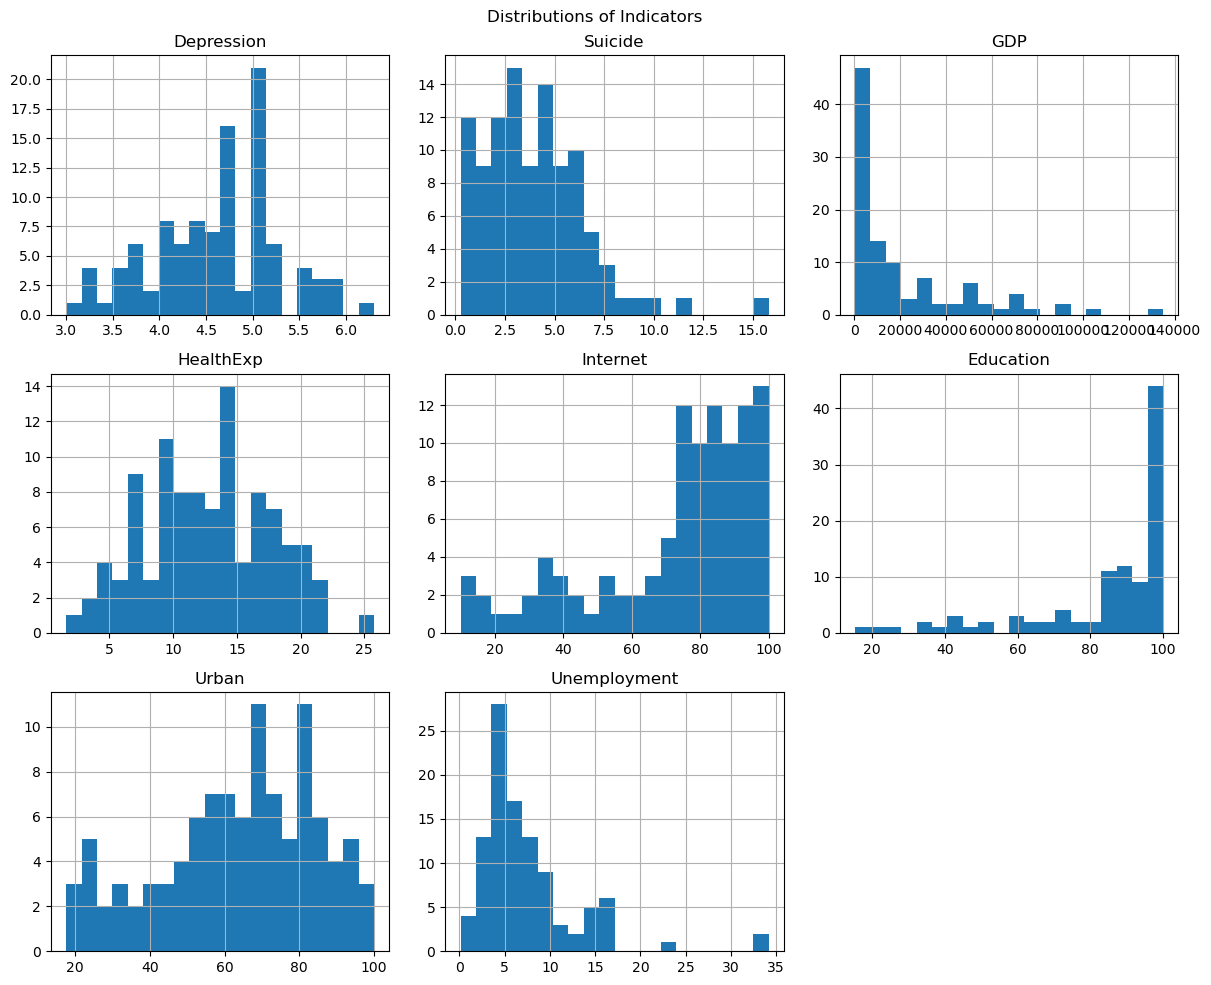

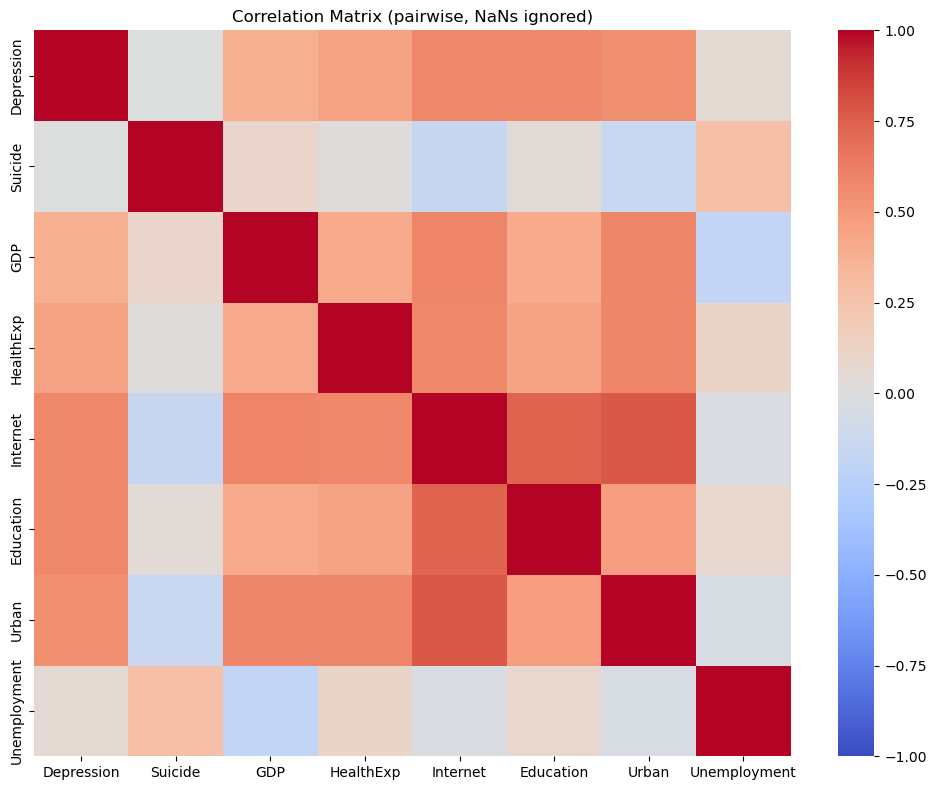

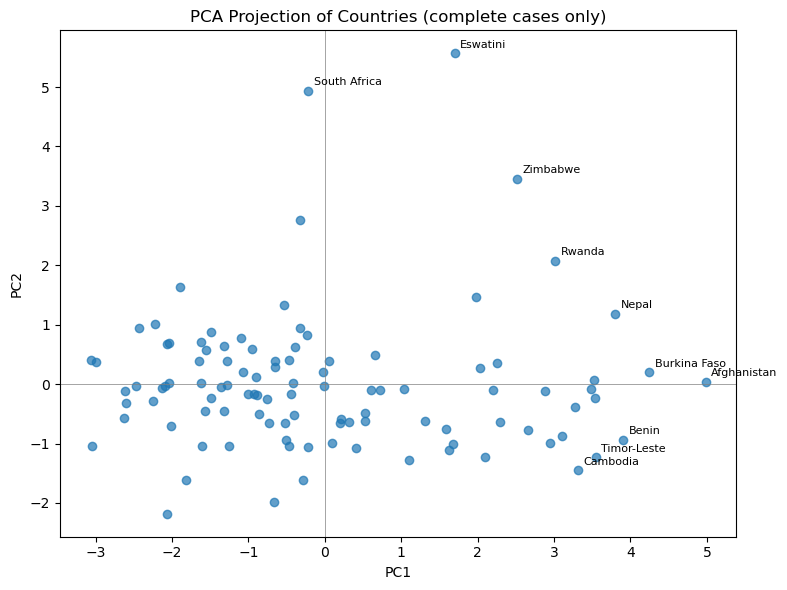

Explained variance ratio (PC1, PC2): [0.46972044 0.16732956]   — cumulative: 0.6370500029500779

Top absolute loadings on PC1:
                   PC1       PC2
Internet     -0.471677 -0.082052
Urban        -0.439777 -0.119034
Education    -0.400043  0.143646
Depression   -0.384343  0.102867
HealthExp    -0.375839  0.131398
GDP          -0.366314 -0.089865
Suicide       0.030129  0.656338
Unemployment  0.003766  0.701258

Top absolute loadings on PC2:
                   PC1       PC2
Unemployment  0.003766  0.701258
Suicide       0.030129  0.656338
Education    -0.400043  0.143646
HealthExp    -0.375839  0.131398
Urban        -0.439777 -0.119034
Depression   -0.384343  0.102867
GDP          -0.366314 -0.089865
Internet     -0.471677 -0.082052

Preprocessing complete. Saved as C:\Users\anude\DM Project\cleaned_dataset_DM.csv

Top association rules:
                         antecedents        consequents   support  confidence  \
122  (Education_high, HealthExp_mid)  (Depression_high)  0.1

In [202]:
# ==============================================================
# WHO (Depression, Suicide) + World Bank indicators
# INNER merge, no global imputation
# EDA + PCA + (optional) Association Rules
# ==============================================================

from pathlib import Path
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# -----------------------------
# Config
# -----------------------------
DATA_DIR = "."           # same folder as your notebook/script
YEAR_WB  = "2021"
MERGE_HOW = "inner"      # intersection of countries
DO_PLOTS = True          # set False to skip plots
DO_ASSOC_RULES = True   # set True (pip install mlxtend)

print("CWD:", Path(".").resolve())

# -----------------------------
# Utilities
# -----------------------------
def find_file(patterns):
    if isinstance(patterns, str):
        patterns = [patterns]
    for pat in patterns:
        p = Path(pat)
        if p.exists():
            return str(p)
        hits = glob.glob(pat)
        if hits:
            return hits[0]
    raise FileNotFoundError(f"No file matched any of: {patterns}")

def read_csv_any(path):
    encs = ["utf-8", "utf-8-sig", "latin1", "cp1252"]
    seps = [None, ",", ";", "\t"]  # None => sniff via python engine
    last = None
    for enc in encs:
        for sep in seps:
            try:
                if sep is None:
                    return pd.read_csv(path, encoding=enc, sep=sep, engine="python", on_bad_lines="skip")
                else:
                    return pd.read_csv(path, encoding=enc, sep=sep, engine="c", on_bad_lines="skip")
            except Exception as e:
                last = e
    raise last

def read_excel_any(path):
    try:
        return pd.read_excel(path)
    except Exception:
        return pd.read_excel(path, engine="openpyxl")

def read_table_any(path):
    suf = Path(path).suffix.lower()
    if suf in {".xlsx", ".xls"}:
        return read_excel_any(path)
    if suf in {".csv", ".txt"} or suf == "":
        try:
            return read_csv_any(path)
        except Exception:
            return read_excel_any(path)
    try:
        return read_csv_any(path)
    except Exception:
        return read_excel_any(path)

def normalize_country_names(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.strip().str.replace(r"\s+\(.*\)$", "", regex=True)
    fixes = {
        "United States of America": "United States",
        "Russian Federation": "Russia",
        "Viet Nam": "Vietnam",
        "Iran (Islamic Republic of)": "Iran",
        "Czechia": "Czech Republic",
        "Korea, Rep.": "South Korea",
        "Korea (Republic of)": "South Korea",
        "Korea, Dem. People’s Rep.": "North Korea",
        "Egypt, Arab Rep.": "Egypt",
        "Bahamas, The": "Bahamas",
        "Gambia, The": "Gambia",
        "Congo, Dem. Rep.": "DR Congo",
        "Congo, Rep.": "Congo",
        "Yemen, Rep.": "Yemen",
        "Syrian Arab Republic": "Syria",
        "Lao PDR": "Laos",
        "Hong Kong SAR, China": "Hong Kong",
        "Macao SAR, China": "Macao",
        "Brunei Darussalam": "Brunei",
    }
    return s.replace(fixes)

# -----------------------------
# WHO helpers (header & country detection)
# -----------------------------
_multi_sep = re.compile(r"[,\t;]+")

def _split_multi(line: str):
    return [p for p in _multi_sep.split(line) if p != ""]

def _read_text_lines(path: str):
    encs = ["utf-8", "utf-8-sig", "latin1", "cp1252"]
    for enc in encs:
        try:
            with open(path, "r", encoding=enc, errors="replace") as f:
                return f.readlines()
        except Exception:
            continue
    return []

def _reparse_from_header(filename: str, header_idx: int):
    encs = ["utf-8", "utf-8-sig", "latin1", "cp1252"]
    for enc in encs:
        try:
            return pd.read_csv(
                filename,
                engine="python",
                sep=r"[,\t;]+",
                header=header_idx,
                on_bad_lines="skip",
                dtype=str,
                encoding=enc,
            )
        except Exception:
            continue
    # last resort
    return pd.read_csv(filename, header=header_idx, engine="python", dtype=str)

def _choose_country_column(df: pd.DataFrame):
    # Prefer known names
    for c in ("Location", "Country", "SpatialDimValue"):
        if c in df.columns:
            return c
    # else guess based on being stringy & country-like
    sample_countries = set("""
        United States United Kingdom Canada Australia India China Japan Germany France Italy Spain
        Sweden Norway Finland Denmark Netherlands Belgium Switzerland Austria Ireland Portugal
        Brazil Argentina Chile Mexico Colombia Peru South Africa Nigeria Kenya Egypt Morocco
        Russia Ukraine Poland Czech Republic Greece Turkey Israel Saudi Arabia UAE Iran Iraq
        Indonesia Malaysia Thailand Vietnam Philippines Singapore South Korea North Korea Taiwan
        New Zealand Pakistan Bangladesh Sri Lanka Nepal Ethiopia Ghana Tanzania Algeria Tunisia
    """.split())
    best, best_hits = None, -1
    for col in df.columns:
        vals = df[col].astype(str).str.strip()
        alpha_ratio = vals.str.match(r"^[A-Za-z .,'-]+$").mean()
        if alpha_ratio < 0.5:
            continue
        hits = sum(v in sample_countries for v in vals.head(200))
        if hits > best_hits:
            best, best_hits = col, hits
    return best

# filename → exact WHO value column (as you specified)
WHO_VALUE_COL = {
    "depression_prevalence": "FactValueString",
    "suicide_rates": "FactValueForMeasure",
}

def load_who_exact(pattern, out_col):
    fn = find_file(pattern)
    df = read_table_any(fn)

    # If not properly headered, detect header row containing Location & Period/Value
    if not any(c in df.columns for c in ["Location", "Country", "SpatialDimValue"]):
        lines = _read_text_lines(fn)
        header_idx = None
        cand_vals = ("FactValueNumeric", "FactValueString", "FactValueForMeasure", "NumericValue", "Value", "ValueNumeric")
        for i, line in enumerate(lines):
            parts = _split_multi(line.strip())
            if "Location" in parts and (("Period" in parts) or any(c in parts for c in cand_vals)):
                header_idx = i
                break
        if header_idx is not None:
            df = _reparse_from_header(fn, header_idx)

    country_col = _choose_country_column(df)
    if not country_col:
        print(f"[WHO] {fn}: no Location/Country-like column; skipping")
        return pd.DataFrame(columns=["Country", out_col])

    # Choose value column by mapping (file name)
    lower = Path(fn).name.lower()
    mapped = None
    for key, col in WHO_VALUE_COL.items():
        if key in lower and col in df.columns:
            mapped = col
            break
    if not mapped:
        print(f"[WHO] {fn}: expected value column not found; columns: {list(df.columns)[:12]}")
        return pd.DataFrame(columns=["Country", out_col])

    # Latest year if Period exists
    if "Period" in df.columns:
        df = df.loc[:, ~df.columns.duplicated()].copy()
        df["Period"] = pd.to_numeric(df["Period"], errors="coerce")
        df = df.dropna(subset=["Period"])
        df = df.sort_values([country_col, "Period"]).groupby(country_col, as_index=False).tail(1)

    # Convert to numeric safely (handles 1,234.56 vs 12,3 & stray dashes)
    s = df[mapped].astype(str).str.strip().replace({"–": None, "-": None, "": None})
    s = np.where(pd.Series(s).str.contains(r"\.", regex=True),
                 pd.Series(s).str.replace(",", "", regex=False),
                 pd.Series(s).str.replace(",", ".", regex=False))
    vals = pd.to_numeric(s, errors="coerce")

    out = pd.DataFrame({
        "Country": normalize_country_names(df[country_col]),
        out_col: vals
    }).dropna(subset=[out_col])
    return out

# -----------------------------
# World Bank loader
# -----------------------------
def load_wb_csv(pattern, out_col, year=YEAR_WB, country_col="Country Name"):
    fn = find_file(pattern)
    df = read_table_any(fn)
    # WB CSVs often have 4 metadata rows
    if not any(str(c).isdigit() for c in df.columns):
        try:
            df = pd.read_csv(fn, skiprows=4)
        except Exception:
            pass
    years = sorted([c for c in df.columns if str(c).isdigit()], key=int)
    if not years:
        print(f"[WB] {fn}: no year columns; skipping")
        return pd.DataFrame(columns=["Country", out_col])
    y = year if year in df.columns else years[-1]
    out = df[[country_col, y]].copy()
    out.columns = ["Country", out_col]
    out["Country"] = normalize_country_names(out["Country"])
    out[out_col] = pd.to_numeric(out[out_col], errors="coerce")
    out = out.dropna(subset=[out_col])
    return out

# -----------------------------
# File patterns (ONLY the datasets you want)
# -----------------------------
WHO_DEPRESSION = [f"{DATA_DIR}/depression_prevalence*"]
WHO_SUICIDE    = [f"{DATA_DIR}/suicide_rates*"]

WB_GDP        = [f"{DATA_DIR}/gdp_per_capita*"]
WB_HEALTH     = [f"{DATA_DIR}/health_expenditure*"]
WB_INTERNET   = [f"{DATA_DIR}/internet_usage*"]
WB_EDUCATION  = [f"{DATA_DIR}/education_attainment*"]
WB_URBAN      = [f"{DATA_DIR}/urban_population*"]
WB_UNEMPLOY   = [f"{DATA_DIR}/unemployment*"]

# -----------------------------
# Run: load + merge
# -----------------------------
print("\nLoading WHO…")
depr_df = load_who_exact(WHO_DEPRESSION, "Depression")
suic_df = load_who_exact(WHO_SUICIDE, "Suicide")

print("\nLoading World Bank…")
gdp_df   = load_wb_csv(WB_GDP,       "GDP")
hexp_df  = load_wb_csv(WB_HEALTH,    "HealthExp")
net_df   = load_wb_csv(WB_INTERNET,  "Internet")
edu_df   = load_wb_csv(WB_EDUCATION, "Education")
urb_df   = load_wb_csv(WB_URBAN,     "Urban")
unemp_df = load_wb_csv(WB_UNEMPLOY,  "Unemployment")

dfs = [depr_df, suic_df, gdp_df, hexp_df, net_df, edu_df, urb_df, unemp_df]
names = ["Depression","Suicide","GDP","HealthExp","Internet","Education","Urban","Unemployment"]
nonempty = [(n, df) for n, df in zip(names, dfs) if df is not None and len(df) > 0]
print("Loaded frames (rows):", {n: len(df) for n, df in nonempty})

# INNER merge (only countries present in ALL selected datasets)
if not nonempty:
    merged = pd.DataFrame(columns=["Country"])
else:
    merged = nonempty[0][1]
    for _, df in nonempty[1:]:
        merged = merged.merge(df, on="Country", how=MERGE_HOW)

print(f"Merged dataset shape ({MERGE_HOW}): {merged.shape}")
if "Country" in merged.columns:
    print("Countries after merge:", merged["Country"].nunique())

# ---------- No global imputation; just summarize missingness ----------
if merged.shape[0] > 0:
    print("\nMissingness summary (fraction of NaN per column):")
    miss = merged.isna().mean().sort_values(ascending=False)
    print(miss)

# ---------- Quick EDA (no filling) ----------
if DO_PLOTS and merged.shape[0] > 0:
    merged.drop(columns=["Country"]).hist(figsize=(12, 10), bins=20)
    plt.suptitle("Distributions of Indicators")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 8))
    corr = merged.drop(columns=["Country"]).corr(numeric_only=True)
    sns.heatmap(corr, annot=False, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Correlation Matrix (pairwise, NaNs ignored)")
    plt.tight_layout()
    plt.show()

# ---------- PCA preview with outlier labels ----------
if DO_PLOTS and merged.shape[0] > 1:
    features = merged.drop(columns=["Country"])
    features_num = features.select_dtypes(include=[np.number])

    # Keep only complete cases for PCA
    complete_pca = features_num.dropna(axis=0)
    dropped = features_num.shape[0] - complete_pca.shape[0]
    if dropped > 0:
        print(f"PCA: dropping {dropped} rows with missing values out of {features_num.shape[0]} total.")

    if complete_pca.shape[0] >= 2:
        # Fit PCA
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(complete_pca)
        pca = PCA(n_components=2, random_state=42)
        X_pca = pca.fit_transform(X_scaled)

        # Build a scores DataFrame with countries
        scores = pd.DataFrame(X_pca, columns=["PC1", "PC2"], index=complete_pca.index)
        scores["Country"] = merged.loc[complete_pca.index, "Country"].values

        # Compute outlier-ness as Euclidean distance from the centroid in PC space
        pc_mean = scores[["PC1", "PC2"]].mean(axis=0)
        dists = np.linalg.norm(scores[["PC1", "PC2"]] - pc_mean, axis=1)
        scores["dist_from_center"] = dists

        # How many labels to show? Tweak this:
        OUTLIER_K = 10

        # Pick top-K farthest points
        to_label = scores.nlargest(OUTLIER_K, "dist_from_center")

        # Plot
        plt.figure(figsize=(8, 6))
        plt.scatter(scores["PC1"], scores["PC2"], alpha=0.7)
        plt.title("PCA Projection of Countries (complete cases only)")
        plt.xlabel("PC1")
        plt.ylabel("PC2")

        # Add labels with a small offset to reduce overlap
        # (Simple jitter; for fancier collision-avoidance consider 'adjustText' library)
        for _, r in to_label.iterrows():
            plt.annotate(
                r["Country"],
                (r["PC1"], r["PC2"]),
                xytext=(4, 4), textcoords="offset points",
                fontsize=8
            )

        # Helpful axes lines
        plt.axhline(0, lw=0.5, color="grey")
        plt.axvline(0, lw=0.5, color="grey")

        plt.tight_layout()
        plt.show()

        # (Optional) print variance explained + top loadings for interpretation
        print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_[:2],
              "  — cumulative:", pca.explained_variance_ratio_[:2].sum())
        loadings = pd.DataFrame(
            pca.components_[:2].T,
            columns=["PC1", "PC2"],
            index=complete_pca.columns
        )
        print("\nTop absolute loadings on PC1:")
        print(loadings.reindex(loadings["PC1"].abs().sort_values(ascending=False).index).head(8))
        print("\nTop absolute loadings on PC2:")
        print(loadings.reindex(loadings["PC2"].abs().sort_values(ascending=False).index).head(8))

    else:
        print("PCA: not enough complete rows to plot.")

# ---------- Save (no imputation applied) ----------
out_path = Path("cleaned_dataset_DM.csv")
merged.to_csv(out_path, index=False)
print(f"\nPreprocessing complete. Saved as {out_path.resolve()}")

# ---------- Optional: Association Rules (drop incomplete rows only for AR step) ----------
if DO_ASSOC_RULES and merged.shape[0] > 0:
    try:
        from mlxtend.frequent_patterns import apriori, association_rules
    except Exception:
        print("mlxtend not installed; skip rules. Install with: pip install mlxtend")
    else:
        df = merged.copy()

        # Choose numeric columns to discretize (exclude 'Country')
        num_cols = [c for c in df.columns if c != "Country" and pd.api.types.is_numeric_dtype(df[c])]
        if not num_cols:
            print("Association rules: no numeric columns to discretize.")
        else:
            # Drop rows with NaNs in any of the used columns for this step only
            df_ar = df[["Country"] + num_cols].dropna(axis=0)
            dropped_ar = df.shape[0] - df_ar.shape[0]
            if dropped_ar > 0:
                print(f"Association rules: dropped {dropped_ar} rows with NaNs (rule-mining step only).")

            def tertile_labels(s, prefix):
                q = s.quantile([0.33, 0.67])
                return pd.cut(s, [-np.inf, q.iloc[0], q.iloc[1], np.inf],
                              labels=[f"{prefix}_low", f"{prefix}_mid", f"{prefix}_high"])

            X = pd.DataFrame({c: tertile_labels(df_ar[c], c) for c in num_cols})

            # Targets (optional) — top quartile flags if those columns exist
            targets = {}
            for tcol in ["Depression", "Suicide"]:
                if tcol in df_ar.columns:
                    cut = df_ar[tcol].quantile(0.75)
                    targets[f"{tcol}_high"] = df_ar[tcol] >= cut

            items = pd.get_dummies(X, prefix="", prefix_sep="")
            transactions = pd.concat([items, pd.DataFrame(targets)], axis=1).fillna(False).astype(bool)

            freq = apriori(transactions, min_support=0.10, use_colnames=True)
            rules = association_rules(freq, metric="confidence", min_threshold=0.6)

            if targets:
                tgt_names = list(targets.keys())
                rules = rules[rules["consequents"].apply(lambda s: any(x in s for x in tgt_names))]

            rules = rules.sort_values(["lift", "confidence", "support"], ascending=False)

            def is_redundant(df_rules, i):
                a_i = df_rules.iloc[i]["antecedents"]
                c_i = df_rules.iloc[i]["consequents"]
                for j in range(0, i):
                    a_j = df_rules.iloc[j]["antecedents"]
                    c_j = df_rules.iloc[j]["consequents"]
                    if c_i == c_j and a_j.issubset(a_i) and df_rules.iloc[j]["lift"] >= df_rules.iloc[i]["lift"]:
                        return True
                return False

            mask = [not is_redundant(rules, i) for i in range(len(rules))]
            rules = rules[mask].head(30)

            cols = ["antecedents","consequents","support","confidence","lift","leverage","conviction"]
            print("\nTop association rules:")
            print(rules[cols])

            rules_out = Path("association_rules.csv")
            rsave = rules.copy()
            rsave["antecedents"] = rsave["antecedents"].apply(lambda s: ", ".join(sorted(list(s))))
            rsave["consequents"]  = rsave["consequents"].apply(lambda s: ", ".join(sorted(list(s))))
            rsave.to_csv(rules_out, index=False)
            print(f"Saved rules to {rules_out.resolve()}")


In [204]:
print(merged)

         Country  Depression  Suicide           GDP  HealthExp  Internet  \
0    Afghanistan         3.3     3.70    356.496214   3.961011      16.5   
1        Albania         4.8     1.74   6413.282808   9.141131      79.3   
2         Angola         3.6     6.34   1925.874661   8.777366      39.4   
3        Armenia         5.0     0.68   4685.179971   7.634966      78.6   
4      Australia         5.9     6.08  60607.778861  19.309410      97.0   
..           ...         ...      ...           ...        ...       ...   
98       Uruguay         5.0     8.90  17881.818721  21.690212      87.6   
99    Uzbekistan         4.2     6.54   2258.519641   9.897934      76.6   
100      Vietnam         4.0     3.94   3704.193559   9.740695      74.2   
101       Zambia         4.0     5.54   1127.160779   9.254849      32.5   
102     Zimbabwe         4.0    15.79   1724.387271   5.211667      37.1   

      Education   Urban  Unemployment  
0     15.250000  26.314        11.994  
1     9

In [205]:
df = merged.copy()

# Choose numeric columns to discretize (exclude 'Country')
num_cols = [c for c in df.columns if c != "Country" and pd.api.types.is_numeric_dtype(df[c])]
if not num_cols:
    print("No numeric columns to discretize.")
else:
    # Drop rows with NaNs in any of the used columns for this step only
    df_ar = df[["Country"] + num_cols].dropna(axis=0)
    dropped_ar = df.shape[0] - df_ar.shape[0]
    if dropped_ar > 0:
        print(f"Association rules: dropped {dropped_ar} rows with NaNs (rule-mining step only).")

    def tertile_labels(s, prefix):
        q = s.quantile([0.33, 0.67])
        return pd.cut(s, [-np.inf, q.iloc[0], q.iloc[1], np.inf],
                      labels=[f"{prefix}_low", f"{prefix}_mid", f"{prefix}_high"])

    X = pd.DataFrame({c: tertile_labels(df_ar[c], c) for c in num_cols})
    print(X)


          Depression       Suicide       GDP       HealthExp       Internet  \
0     Depression_low   Suicide_mid   GDP_low   HealthExp_low   Internet_low   
1     Depression_mid   Suicide_low   GDP_mid   HealthExp_low   Internet_mid   
2     Depression_low  Suicide_high   GDP_low   HealthExp_low   Internet_low   
3     Depression_mid   Suicide_low   GDP_low   HealthExp_low   Internet_mid   
4    Depression_high  Suicide_high  GDP_high  HealthExp_high  Internet_high   
..               ...           ...       ...             ...            ...   
98    Depression_mid  Suicide_high   GDP_mid  HealthExp_high  Internet_high   
99    Depression_low  Suicide_high   GDP_low   HealthExp_low   Internet_mid   
100   Depression_low   Suicide_mid   GDP_low   HealthExp_low   Internet_mid   
101   Depression_low  Suicide_high   GDP_low   HealthExp_low   Internet_low   
102   Depression_low  Suicide_high   GDP_low   HealthExp_low   Internet_low   

          Education       Urban       Unemployment 

In [207]:
# --- Continue right after you've created X ---

# 1) Build transactions from X
# Each row has one label per feature, e.g. ["GDP_high", "Internet_mid", ...]
# Ensure strings and no NaNs.
X_str = X.astype(str)

transactions = []
for i in range(len(X_str)):
    # Using list(...) is fine because each column contributes exactly one item
    tx = [val for val in X_str.iloc[i].tolist() if val != "nan"]
    transactions.append(tuple(tx))  # tuples are hashable; good practice

num_records = len(transactions)
print(f"# transactions: {num_records}")

# (Optional) quick sanity check: no empty transactions
transactions = [t for t in transactions if len(t) > 0]
if len(transactions) < num_records:
    print(f"Removed {num_records - len(transactions)} empty transactions.")
num_records = len(transactions)

# 2) Mine frequent itemsets with pyfpgrowth
try:
    import pyfpgrowth
except Exception:
    print("pyfpgrowth not installed; install with: pip install pyfpgrowth")
else:
    sigma = max(2, int(0.10 * num_records))  # absolute support count threshold
    min_support = sigma / num_records if num_records else 0.0
    print(f"Minimum support (fraction): {min_support:.4f}  (sigma={sigma}, N={num_records})")

    if num_records == 0 or sigma > num_records:
        print("Not enough transactions to mine patterns at this sigma.")
        patterns = {}
    else:
        # transactions: list[tuple[str, ...]]
        patterns = pyfpgrowth.find_frequent_patterns(transactions, sigma)

    # patterns is a dict: { itemset_tuple: support_count }
    print(f"Found {len(patterns)} frequent itemsets at sigma={sigma}.")

    # Pretty print top itemsets sorted by support count
    if patterns:
        top = sorted(patterns.items(), key=lambda kv: kv[1], reverse=True)[:30]
        print("\nTop frequent itemsets (itemset -> count):")
        for items, count in top:
            print(f"{', '.join(items)} -> {count}")


# transactions: 103
Minimum support (fraction): 0.0971  (sigma=10, N=103)
Found 281 frequent itemsets at sigma=10.

Top frequent itemsets (itemset -> count):
Depression_low -> 40
Internet_mid -> 36
Depression_mid -> 35
Depression_low, GDP_low -> 30
Depression_low, Internet_low -> 30
GDP_high, Internet_high -> 28
GDP_low, Internet_low -> 28
GDP_low, HealthExp_low -> 26
Depression_low, HealthExp_low -> 26
Depression_low, GDP_low, Internet_low -> 26
Education_low, Internet_low -> 26
Depression_low, Education_low -> 26
Depression_low, Urban_low -> 26
Internet_low, Urban_low -> 25
Internet_high, Urban_high -> 24
GDP_mid, Internet_mid -> 24
Depression_low, GDP_low, HealthExp_low -> 23
Depression_low, Education_low, GDP_low -> 23
Education_low, GDP_low, Internet_low -> 23
Depression_low, Education_low, Internet_low -> 23
Depression_low, Internet_low, Urban_low -> 23
GDP_high, Urban_high -> 23
GDP_low, HealthExp_low, Internet_low -> 22
Depression_low, Education_low, GDP_low, Internet_low -> 22

In [208]:
num_frequent_itemsets = len(patterns)
max_itemset_size = max(len(itemset) for itemset in patterns)
print(f'Number of frequent itemsets: {num_frequent_itemsets}')
print(f'Maximun size of frequent itemsets: {max_itemset_size}')

Number of frequent itemsets: 281
Maximun size of frequent itemsets: 6


In [209]:
support = {key: value / len(df) for key, value in patterns.items()}
support

{('Depression_high', 'Unemployment_mid'): 0.0970873786407767,
 ('Depression_high', 'GDP_mid'): 0.0970873786407767,
 ('Depression_high', 'Education_mid'): 0.0970873786407767,
 ('Depression_high', 'HealthExp_high'): 0.10679611650485436,
 ('Depression_high', 'Unemployment_low'): 0.10679611650485436,
 ('Depression_high', 'Urban_high'): 0.11650485436893204,
 ('Depression_high', 'Urban_mid'): 0.1262135922330097,
 ('Depression_high', 'Suicide_mid'): 0.1262135922330097,
 ('Depression_high', 'Internet_high'): 0.13592233009708737,
 ('Depression_high', 'GDP_high', 'Internet_high'): 0.11650485436893204,
 ('Depression_high', 'HealthExp_mid'): 0.13592233009708737,
 ('Depression_high', 'Education_high', 'HealthExp_mid'): 0.11650485436893204,
 ('Depression_high', 'Internet_mid'): 0.13592233009708737,
 ('Depression_high', 'Education_high'): 0.1650485436893204,
 ('Depression_high', 'GDP_high'): 0.1650485436893204,
 ('Internet_high', 'Suicide_mid'): 0.10679611650485436,
 ('GDP_high', 'Internet_high', 'Su

In [210]:
num_records = len(df)
# define range for min-support values (0.001 to 0.01)
min_support_values = [0.1, 0.2, 0.3, 0.4]

In [211]:
for min_support in min_support_values:
    # the second parameter of the function 'find_frequent_patterns' is the support count, NOT the min-support, so you have to calculate it
    support_count = min_support * num_records
    patterns = pyfpgrowth.find_frequent_patterns(transactions, support_count)
    support = {key: value / len(df) for key, value in patterns.items()}
    print(f"Minimum support: {min_support}, Support count: {support_count:.0f}")
    print(f'Found {len(patterns)} patterns')
    print('Patterns', patterns)
    print('Support', support)
    print()

Minimum support: 0.1, Support count: 10
Found 224 patterns
Patterns {('Depression_high', 'HealthExp_high'): 11, ('Depression_high', 'Unemployment_low'): 11, ('Depression_high', 'Urban_high'): 12, ('Depression_high', 'Urban_mid'): 13, ('Depression_high', 'Suicide_mid'): 13, ('Depression_high', 'Internet_high'): 14, ('Depression_high', 'GDP_high', 'Internet_high'): 12, ('Depression_high', 'HealthExp_mid'): 14, ('Depression_high', 'Education_high', 'HealthExp_mid'): 12, ('Depression_high', 'Internet_mid'): 14, ('Depression_high', 'Education_high'): 17, ('Depression_high', 'GDP_high'): 17, ('Internet_high', 'Suicide_mid'): 11, ('HealthExp_mid', 'Internet_high'): 12, ('Internet_high', 'Unemployment_low'): 12, ('Internet_high', 'Suicide_high'): 14, ('GDP_high', 'Internet_high', 'Suicide_high'): 11, ('Education_high', 'Internet_high'): 16, ('Education_high', 'GDP_high', 'Internet_high'): 14, ('Internet_high', 'Unemployment_mid'): 16, ('GDP_high', 'Internet_high', 'Unemployment_mid'): 16, ('Ed

In [212]:
min_support = 0.15
support_count = min_support * num_records
confidence = 0.5
patterns = pyfpgrowth.find_frequent_patterns(transactions, support_count)
rules = pyfpgrowth.generate_association_rules(patterns, confidence)
rules

{('GDP_high', 'Internet_high'): (('Urban_high',), 0.75),
 ('GDP_high', 'Unemployment_mid'): (('Internet_high',), 0.8888888888888888),
 ('Internet_high', 'Unemployment_mid'): (('GDP_high',), 1.0),
 ('GDP_high', 'HealthExp_high'): (('Internet_high',), 0.8421052631578947),
 ('HealthExp_high', 'Internet_high'): (('GDP_high',), 0.8888888888888888),
 ('GDP_high', 'Urban_high'): (('Internet_high',), 0.9130434782608695),
 ('Internet_high', 'Urban_high'): (('GDP_high',), 0.875),
 ('Depression_low',): (('Urban_low',), 0.65),
 ('GDP_low',): (('HealthExp_low', 'Urban_low'), 0.6470588235294118),
 ('Depression_low', 'GDP_low'): (('HealthExp_low', 'Urban_low'),
  0.6666666666666666),
 ('Depression_low', 'HealthExp_low'): (('GDP_low', 'Urban_low'),
  0.7692307692307693),
 ('GDP_low', 'HealthExp_low'): (('Urban_low',), 0.8461538461538461),
 ('Depression_low', 'Internet_low'): (('Urban_low',), 0.7666666666666667),
 ('GDP_low',
  'Internet_low'): (('Depression_low',
   'HealthExp_low',
   'Urban_low'), 0

In [213]:
min_confidence_range = [0.1, 0.3, 0.5, 0.7, 0.9]
for min_conf in min_confidence_range:
    rules = pyfpgrowth.generate_association_rules(patterns, min_conf)
    num_rules = len(rules)
    print(f"Minimum confidence: {min_conf}")
    print(f"Number of generated rules: {num_rules}")
    print()

Minimum confidence: 0.1
Number of generated rules: 55

Minimum confidence: 0.3
Number of generated rules: 55

Minimum confidence: 0.5
Number of generated rules: 53

Minimum confidence: 0.7
Number of generated rules: 50

Minimum confidence: 0.9
Number of generated rules: 31



In [214]:
import pyfpgrowth

# inputs
min_support = 0.15
confidence = 0.5

# associations is your list of transactions, e.g. [['a','b'], ['b','c'], ...]
num_records = len(transactions)
support_count = max(1, int(min_support * num_records))  # at least 1

# mine patterns and rules
patterns = pyfpgrowth.find_frequent_patterns(transactions, support_count)
rules = pyfpgrowth.generate_association_rules(patterns, confidence)

# convert support counts -> support proportions for easy lookup
# patterns: {itemset_tuple: count}
support_prop = {k: v / num_records for k, v in patterns.items()}

def compute_support(itemset, transactions):
    count = 0
    itemset = set(itemset)
    for transaction in transactions:
        if itemset.issubset(transaction):
            count += 1
    return count / len(transactions)

# assemble rules with lift
rules_with_lift = []
for antecedent, (consequent, conf) in rules.items():
    supp_Y = compute_support(consequent, transactions)
    supp_X = compute_support(antecedent, transactions)
    supp_XY = compute_support(list(antecedent) + list(consequent), transactions)

    lift = conf / supp_Y if supp_Y > 0 else float("nan")


    rules_with_lift.append({
        "antecedent": antecedent,
        "consequent": consequent,
        "confidence": conf,
        "lift": lift,
        "support_X": supp_X,
        "support_Y": supp_Y,
        "support_XY": supp_XY
    })

# rules_with_lift now contains lift for each rule
print(rules_with_lift)

[{'antecedent': ('GDP_high', 'Internet_high'), 'consequent': ('Urban_high',), 'confidence': 0.75, 'lift': 2.2720588235294117, 'support_X': 0.27184466019417475, 'support_Y': 0.3300970873786408, 'support_XY': 0.20388349514563106}, {'antecedent': ('GDP_high', 'Unemployment_mid'), 'consequent': ('Internet_high',), 'confidence': 0.8888888888888888, 'lift': 2.774410774410774, 'support_X': 0.17475728155339806, 'support_Y': 0.32038834951456313, 'support_XY': 0.1553398058252427}, {'antecedent': ('Internet_high', 'Unemployment_mid'), 'consequent': ('GDP_high',), 'confidence': 1.0, 'lift': 3.0294117647058822, 'support_X': 0.1553398058252427, 'support_Y': 0.3300970873786408, 'support_XY': 0.1553398058252427}, {'antecedent': ('Education_mid', 'Internet_high'), 'consequent': ('Urban_high',), 'confidence': 0.9375, 'lift': 2.8400735294117645, 'support_X': 0.1553398058252427, 'support_Y': 0.3300970873786408, 'support_XY': 0.14563106796116504}, {'antecedent': ('Education_mid', 'Urban_high'), 'consequent

In [215]:
import pandas as pd
import numpy as np

# rules_with_lift is your list of dicts from the loop
df_rules = pd.DataFrame(rules_with_lift)

# optional: replace infinite lift (from support_Y == 0) with NaN to avoid top rank
df_rules['lift'] = df_rules['lift'].replace([np.inf, -np.inf], np.nan)

# rank by confidence (higher confidence = rank 1)
df_rules['rank_confidence'] = df_rules['confidence'].rank(method='dense', ascending=False)

# rank by lift (higher lift = rank 1); NaNs will get the worst rank if you want:
df_rules['rank_lift'] = df_rules['lift'].rank(method='dense', ascending=False, na_option='bottom')

# if integer ranks are preferred
df_rules['rank_confidence'] = df_rules['rank_confidence'].astype('Int64')
df_rules['rank_lift'] = df_rules['rank_lift'].astype('Int64')

# sort to view top rules by each metric (optional)
df_by_conf = df_rules.sort_values(['rank_confidence', 'rank_lift'])
df_by_lift = df_rules.sort_values(['rank_lift', 'rank_confidence'])

print(df_rules)

                                           antecedent         consequent  \
0                           (GDP_high, Internet_high)      (Urban_high,)   
1                        (GDP_high, Unemployment_mid)   (Internet_high,)   
2                   (Internet_high, Unemployment_mid)        (GDP_high,)   
3                      (Education_mid, Internet_high)      (Urban_high,)   
4                         (Education_mid, Urban_high)   (Internet_high,)   
..                                                ...                ...   
56  (Depression_low, GDP_low, HealthExp_low, Inter...   (Education_low,)   
57  (Education_low, GDP_low, HealthExp_low, Intern...  (Depression_low,)   
58                                    (Internet_mid,)       (Urban_mid,)   
59                                (Unemployment_mid,)        (GDP_high,)   
60                                  (Depression_mid,)      (Urban_high,)   

    confidence      lift  support_X  support_Y  support_XY  rank_confidence  \
0     0.

In [216]:
# The items of interest
target_items = {
    "Depression_high", "Suicide_high",
    "Depression_mid",  "Suicide_mid",
    "Depression_low",  "Suicide_low"
}

# 2) Antecedent is composed *only* of target items (subset, and non-empty)
mask_subset = df_rules["antecedent"].apply(lambda a: len(a) > 0 and set(a).issubset(target_items))
rules_subset = df_rules[mask_subset].copy()

rules_subset = rules_subset.sort_values(["lift", "confidence"], ascending=False)

print("\nRules with antecedent only from target items:", len(rules_subset))
print(rules_subset)

# 2) Antecedent is composed *only* of target items (subset, and non-empty)
mask_subset = df_rules["consequent"].apply(lambda a: len(a) > 0 and set(a).issubset(target_items))
rules_subset = df_rules[mask_subset].copy()

rules_subset = rules_subset.sort_values(["lift", "confidence"], ascending=False)

print("\nRules with consequent only from target items:", len(rules_subset))
print(rules_subset)


Rules with antecedent only from target items: 2
           antecedent     consequent  confidence      lift  support_X  \
9   (Depression_low,)   (Urban_low,)    0.650000  1.969118   0.388350   
60  (Depression_mid,)  (Urban_high,)    0.514286  1.557983   0.339806   

    support_Y  support_XY  rank_confidence  rank_lift  
9    0.330097    0.252427               28         47  
60   0.330097    0.174757               32         48  

Rules with consequent only from target items: 4
                                           antecedent         consequent  \
57  (Education_low, GDP_low, HealthExp_low, Intern...  (Depression_low,)   
42                          (Internet_low, Urban_low)  (Depression_low,)   
36                (GDP_low, HealthExp_low, Urban_low)  (Depression_low,)   
47  (GDP_low, HealthExp_low, Internet_low, Urban_low)  (Depression_low,)   

    confidence      lift  support_X  support_Y  support_XY  rank_confidence  \
57    0.937500  2.414062   0.155340    0.38835    0.14

In [217]:
import pandas as pd
from pathlib import Path

# ----- targets set -----
target_items = {
    "Depression_high", "Depression_mid", "Depression_low",
    "Suicide_high",    "Suicide_mid",    "Suicide_low",
}

def to_set(x):
    if isinstance(x, (list, tuple, set)): return set(x)
    return {x}

def fmt_items(x):
    return ", ".join(map(str, to_set(x))) if isinstance(x, (list, tuple, set)) else str(x)

# ----- build both subsets -----
# A) antecedent only from target items
mask_ante_targets = df_rules["antecedent"].apply(lambda a: len(to_set(a)) > 0 and to_set(a).issubset(target_items))
rules_ante_targets = (
    df_rules[mask_ante_targets]
    .copy()
    .sort_values(["lift", "confidence"], ascending=False, ignore_index=True)
)

# B) consequent only from target items
mask_conseq_targets = df_rules["consequent"].apply(lambda a: len(to_set(a)) > 0 and to_set(a).issubset(target_items))
rules_conseq_targets = (
    df_rules[mask_conseq_targets]
    .copy()
    .sort_values(["lift", "confidence"], ascending=False, ignore_index=True)
)

# Pretty-print antecedent/consequent for Excel readability
for df in (rules_ante_targets, rules_conseq_targets):
    if "antecedent" in df.columns: df["antecedent"] = df["antecedent"].apply(fmt_items)
    if "consequent" in df.columns: df["consequent"] = df["consequent"].apply(fmt_items)

print(f"Rules with antecedent only from target items: {len(rules_ante_targets)}")
print(f"Rules with consequent only from target items: {len(rules_conseq_targets)}")

# ----- write both to one Excel file -----
out_path = Path("rules_subsets.xlsx")

# pick engine
engine = None
try:
    import xlsxwriter  # noqa
    engine = "xlsxwriter"
except Exception:
    try:
        import openpyxl  # noqa
        engine = "openpyxl"
    except Exception:
        raise ImportError("Install either 'XlsxWriter' or 'openpyxl' to write .xlsx files.")

with pd.ExcelWriter(out_path, engine=engine) as writer:
    rules_ante_targets.to_excel(writer, sheet_name="antecedent_targets", index=False)
    rules_conseq_targets.to_excel(writer, sheet_name="consequent_targets", index=False)

    # auto-width
    if engine == "xlsxwriter":
        for name, df in {"antecedent_targets": rules_ante_targets,
                         "consequent_targets": rules_conseq_targets}.items():
            ws = writer.sheets[name]
            for i, col in enumerate(df.columns):
                maxlen = max(len(str(col)), *(len(str(v)) for v in df[col].head(1000)))
                ws.set_column(i, i, min(max(10, maxlen + 2), 60))
    else:
        from openpyxl.utils import get_column_letter
        for name, df in {"antecedent_targets": rules_ante_targets,
                         "consequent_targets": rules_conseq_targets}.items():
            ws = writer.sheets[name]
            for i, col in enumerate(df.columns, start=1):
                maxlen = max(len(str(col)), *(len(str(v)) for v in df[col].head(1000)))
                ws.column_dimensions[get_column_letter(i)].width = min(max(10, maxlen + 2), 60)

print(f"Saved Excel: {out_path.resolve()}")


Rules with antecedent only from target items: 2
Rules with consequent only from target items: 4
Saved Excel: C:\Users\anude\DM Project\rules_subsets.xlsx


C:\Users\anude\anaconda3\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
C:\Users\anude\anaconda3\Lib\site-packages\openpyxl\writer\excel.py:292: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  workbook.properties.modified = datetime.datetime.utcnow()
